# A calibrated, constrained ensemble

FaIR, like every other simple or complex climate model, is naive. It will produce projections for whatever emissions/concentrations/forcing scenario you ask it to produce projections for. It is up to the user to determine whether these projections are useful and sensible.

We are [developing a set of parameter calibrations](https://github.com/chrisroadmap/fair-calibrate) that reproduce both observed climate change since pre-industrial and assessed climate metrics such as the equilibrium climate sensitivity from the IPCC Sixth Assessement Report.

The calibrations will be continually updated, as new data for surface temperature, ocean heat content, external forcing and emissions become available. For now, we have an IPCC AR6 WG1 version (where observational constraints are generally up to somewhere in the 2014 to 2020 period), and assessments of emergent climate metrics are from the IPCC AR6 WG1 Chapter 7. We use emissions data (historical + SSP) from the Reduced Complexity Model Intercomparison Project which was compiled for IPCC AR6 WG3 Chapter 3. We also have calibration versions for replacing historical CO2 emissions by Global Carbon Project estimates. This is v1.1.0 of the `fair-calibrate` package, and can be obtained from the DOI link below.

A two-step constraining process is produced. The first step ensures that historical simulations match observed climate change to a root-mean-square error of less than 0.16°C. The second step simultaneously distribution-fits to the following assessed ranges:

- equilibrium climate sensitivity (ECS), very likely range 2-5°C, best estimate 3°C
- transient climate response (TCR), very likely range 1.2-2.4°C, best estimate 1.8°C
- global mean surface temperature change 1850-1900 to 1995-2014, very likely range 0.67-0.98°C, best estimate 0.85°C
- effective radiative forcing from aerosol-radiation interactions 1750 to 2005-2014, very likely range -0.6 to 0 W/m², best estimate -0.3 W/m²
- effective radiative forcing from aerosol-cloud interactions 1750 to 2005-2014, very likely range -1.7 to -0.3 W/m², best estimate -1.0 W/m²
- effective radiative forcing from aerosols 1750 to 2005-2014, very likely range -2.0 to -0.6 W/m², best estimate -1.3 W/m²
- ocean heat content change 1971 to 2018, likely range 329-463 ZJ, best estimate 396 ZJ
- CO2 concentrations in 2014, very likely range 396.95-398.15 ppm, best estimate 397.55 ppm
- future warming in SSP245 1995-2014 to 2081-2100, 1.24-2.59°C, best estimate 1.81°C. Note the IPCC constraint was concentration driven, in fair-calibrate v1.1.0 an emissions-driven constraint was used.

1001 posterior ensemble members are produced from an initial prior of 1.5 million.

There are many, many, many different calibration and constraining possibilities, and it depends on your purposes as to what is appropriate. If you care about the carbon cycle, you might want to constrain on TCRE and ZEC in addition, or instead of, some of the other constraints above. Not all constraints are necessarily internally consistent, and there will be some tradeoff; it is impossible to hit the above ranges perfectly. As more constraints are added, this gets harder, or will require larger prior sample sizes.

<a href="https://doi.org/10.5281/zenodo.7694879"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.7694879.svg" align="left"/></a>

## Get required imports

[pooch](https://www.fatiando.org/pooch/latest/) is a useful package that allows downloads of external datasets to your cache, meaning that you don't have to include them in Git repositories (particularly troublesome for large files) or `.gitignore` them (difficult for exact reproduciblity, and easy to forget and accidently commit a large file).

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

### 1. Create FaIR instance

To reproduce an AR6-like run, we want to allow methane lifetime to be affected by all its relevant chemical precursors (NOx, VOCs, etc) so we set the `ch4_method` flag to `Thornhill2021` (see https://docs.fairmodel.net/en/latest/api_reference.html#fair.FAIR for all of the options for initialising `FAIR`).

In [2]:
f = FAIR(ch4_method="Thornhill2021")

### 2. Define time horizon

A lot of analysis uses 2100 as the time horizon, but 2300 is an interesting end point to see the effects of long-term climate change. We'll set 2300 as the last time bound, so the last emissions time point is 2299.5. We could even run to 2500, as the scenarios are defined that far.

In [3]:
f.define_time(1750, 2300, 1)  # start, end, step

### 3. Define scenarios

Since the eight tier 1 & tier 2 SSPs are shipped with RCMIP, and they are quite familiar, we'll use these scenarios. We'll use the `fill_from_rcmip()` function from FaIR, so these have to use the same scenario names that appear in the RCMIP database.

In [4]:
scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]

In [5]:
f.define_scenarios(scenarios)

### 4. Define configs

The constrained dataset contains 1001 ensemble members, and 47 parameters that define the climate response of FaIR. The parameters pertain to `climate_configs` and `species_configs` that produce a wide range of climate responses. We sample from the 11 `climate_configs` parameters that define the [stochastic three-layer energy balance model](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD190589.xml), plus a random seed. Of the other 35 parameters, three vary the behaviour of solar and volcanic forcing and are applied externally. The other 32 vary the behaviour of individual species and override default values of `species_configs` within FaIR (an example being the parameters defining the sensitivity of the carbon cycle feedbacks). Since every species has about 30 configs attached, there's well over a thousand potential parameters that could be modified in FaIR. Outside of the 32 parameters sampled, changing from default values would make little difference, would not be relevant to a particular species, or not be sensible to change.

We'll use `pooch` to retrieve the v1.1 calibration data, and external datasets of solar and volcanic forcing that were pre-prepared for AR6 work.

The name of the `config` axis will be an integer, which relates to the parameter draw from the large prior ensemble used in the calibration and constraining code.

In [6]:
fair_params_1_1_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/7694879/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:9f236c43dd18a36b7b63b94e05f3caab',
)

In [7]:
df_configs = pd.read_csv(fair_params_1_1_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [8]:
configs

Index([    223,     248,     337,    1126,    1483,    2227,    4608,    5683,
          5797,    8678,
       ...
       1487259, 1487663, 1487726, 1488018, 1491376, 1492261, 1495153, 1496559,
       1497149, 1498501],
      dtype='int64', length=1001)

In [9]:
df_configs.head()

,gamma,c1,c2,c3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,...,scale Stratospheric water vapour,scale Contrails,scale Light absorbing particles on snow and ice,scale Land use,scale Volcanic,solar_amplitude,solar_trend,scale CO2,co2_concentration_1750,seed
223,2.542893,4.427776,6.439976,27.811738,1.520582,2.611941,0.791147,1.785763,0.019479,0.224300,...,0.108490,2.909226,1.968794,1.153243,1.174896,1.150642,0.074411,1.113938,280.996949,1444740
248,2.699183,5.652514,12.693147,96.305433,1.451888,2.190332,1.587625,1.503535,0.634219,0.407836,...,1.120879,1.301683,1.608106,1.257000,1.114128,1.235605,-0.043372,1.103832,279.272092,1454715
337,5.560834,4.520785,29.034908,31.431180,1.140293,2.933847,1.202307,1.639030,0.757088,0.525296,...,0.361334,0.788912,0.290387,1.168830,1.044172,0.944002,0.059474,1.168394,280.221119,1490226
1126,9.119766,4.038270,10.507803,136.797996,0.901322,2.853364,1.180568,1.633855,0.842745,0.469932,...,0.092992,1.323717,1.284205,0.765529,1.183536,0.698080,-0.006882,1.027689,276.774836,1805037
1483,1.541741,5.884384,10.171038,144.590161,1.324372,5.830341,0.986666,1.261385,0.493214,0.743539,...,1.774764,1.342722,0.741301,0.816963,0.851670,1.046927,0.011883,0.978011,275.662447,1947480


### 5. Define species and properties

We will use FaIR's default list of 63 species. They are often run with default properties that are included in the model code. However, as part of the v1.1 calibration, some defaults are modified, such as the sensitivity of chemical precursors to methane lifetime. Rather than manually overriding this by setting `species_configs`, it is cleaner to modify the defaults in the CSV file that is read in to define the `species` and `properties`. 

In fact, as this only reads in and defines `species` and `properties` (not `species_configs`), the default (no `filename`) argument could be used here, but it is good practice in my opinion to put species, properties and configs in the same file, and to use the same file to read in `properties` and `species_configs`.

If you're following along at home, feel free to insert a new cell after this one and inspect what the `species` and `properties` actually are.

In [10]:
species, properties = read_properties(filename='data/species_configs_properties_calibration1.1.0.csv')
f.define_species(species, properties)

### 6. Modify run options

Not necessary, as we made all of our choices on initialisation (step 1).

### 7. Create input and output xarrays

If this runs without error, the problem is consistently and completely set up: we then just need to add data.

In [11]:
f.allocate()

### 8a. Fill in emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [12]:
f.fill_from_rcmip()

In [13]:
f.emissions

<xarray.DataArray (timepoints: 550, scenario: 8, config: 1001, specie: 64)>
array([[[[0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan]],

        [[0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
         [0.00950562, 0.29746461,        nan, ...,        nan,
                 nan,        nan],
...
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan]],

        [[0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan],
         [0.        , 0.        ,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.298e+03 2.3e+03
  * scenario    (scenario) <U11 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * config      (config) int64 223 248 337 1126 ... 1496559 1497149 1498501
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

There is an issue with the RCMIP NOx emissions; the units are different for biomass burning emissions (Tg NO/yr) to the other emissions from fossil fuels, industry and agriculture (Tg NO2/yr). v1.1 of the calibration uses the corrected NOx emissions expressed in Tg NO2/yr, so we also have to correct them in FaIR for consistency.

We download the RCMIP emissions file, and pull out the relevant sectors, update the unit, and finally override the correct entry of `f.emissions`.

Notes on the below:
- 46.006 is the molecular weight of NO2 (g/mol).
- 30.006 is the molecular weight of NO (g/mol).
- The final `[:550, None]` is to transfer the data coming in from RCMIP (dimension (750,), a timeseries of annual emissions) into the correct shape for our problem (550, 1001). Since we are looping over the `scenario` dimension and selecting it, and we are selecting NOx from the `species` dimension, these axes are collapsed and we're left with (`timepoints`, `configs`). The RCMIP data starts in 1750 as does our emissions data; if there is a mismatch in the start date, it would be necessary to select the correct slice from the RCMIP `DataFrame` that is loaded in. For a reminder of the dimensioning in FaIR 2.1, see https://docs.fairmodel.net/en/latest/intro.html#dimensionality.

In [14]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1750":"2300",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:550, None]

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [15]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [16]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/volcanic_ERF_monthly_174901-201912.csv',
    known_hash = 'md5:d3ac469ee7d2c2c75fbb656c2c67c4aa',
)

In [17]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

Remembering that everything that is not emissions is on `timebounds`, there is always one more `timebounds` than `timepoints`, so we define arrays of length 551 (1750 to 2300, inclusive).

Volcanic forcing is given monthly, so we average the 12 previous months for each `timebounds` volcanic forcing.

Volcanic forcing here follows the CMIP6 ScenarioMIP convention of a 10 year ramp down to zero from the last year of data (here 2019). Again a little bit of ninja skill with indexing is needed.

In [18]:
solar_forcing = np.zeros(551)
volcanic_forcing = np.zeros(551)
for i, year in enumerate(np.arange(1750, 2021)):
    volcanic_forcing[i] = np.mean(
        df_volcanic.loc[
            ((year - 1) <= df_volcanic["year"]) & (df_volcanic["year"] < year)
        ].erf
    )
volcanic_forcing[271:281] = np.linspace(1, 0, 10) * volcanic_forcing[270]
solar_forcing = df_solar["erf"].loc[1750:2300].values

trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [19]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["scale Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["solar_trend"].values.squeeze(),
    specie="Solar",
)

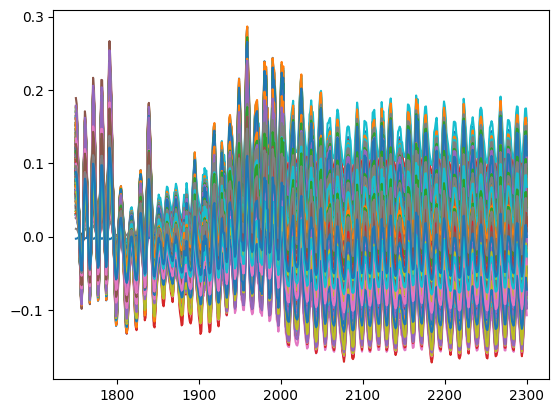

In [20]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie="Solar", scenario="ssp245")]);

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [21]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "c1":"c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "kappa1":"kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["F_4xCO2"])

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [22]:
f.fill_species_configs(filename='data/species_configs_properties_calibration1.1.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [23]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["shape Sulfur"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["shape BC"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["shape OC"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari {specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    "Contrails", 
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"scale {specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["scale minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3 {specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [24]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## 9. Run

In [25]:
f.run()

Running 8008 projections in parallel:   0%|          | 0/550 [00:00<?, ?timesteps/s]

## 10. Analysis

In [26]:
fancy_titles = {
    "ssp119": "SSP1-1.9",
    "ssp126": "SSP1-2.6",
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp434": "SSP4-3.4",
    "ssp460": "SSP4-6.0",
    "ssp534-over": "SSP5-3.4-overshoot",
    "ssp585": "SSP5-8.5",
}

ar6_colors = {
    "ssp119": "#00a9cf",
    "ssp126": "#003466",
    "ssp245": "#f69320",
    "ssp370": "#df0000",
    "ssp434": "#2274ae",
    "ssp460": "#b0724e",
    "ssp534-over": "#92397a",
    "ssp585": "#980002",
}

### Temperature anomaly

We define an anomaly baseline of 1850-1900. This is 51 complete years. As FaIR temperature anomalies are on `timebounds`, we take mid-year temperatures as averages of the bounding `timebounds`; so, 1850.5 is an average of 1850.0 and 1851.0. It means we take an average period of 1850-1901 timebounds with 0.5 weights for 1850 and 1901 and 1.0 weights for other `timebounds`.

In [27]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

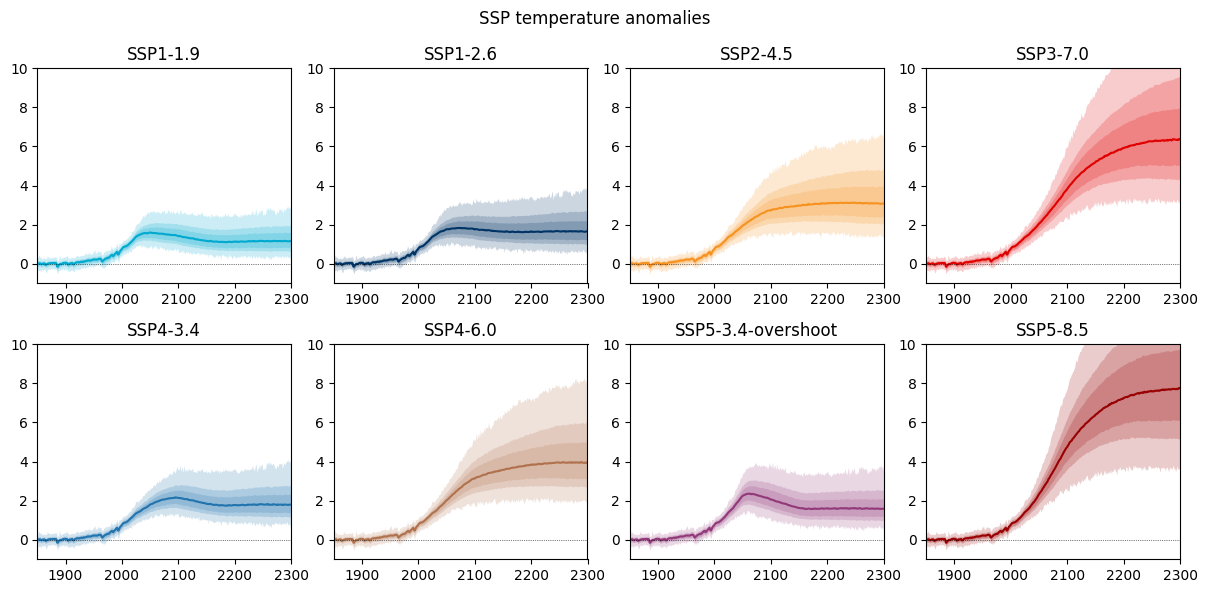

In [28]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
#     ax[i // 4, i % 4].plot(np.arange(1850.5, 2021), gmst, color="k")
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(-1, 10)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP temperature anomalies")
fig.tight_layout()

### CO2 concentrations

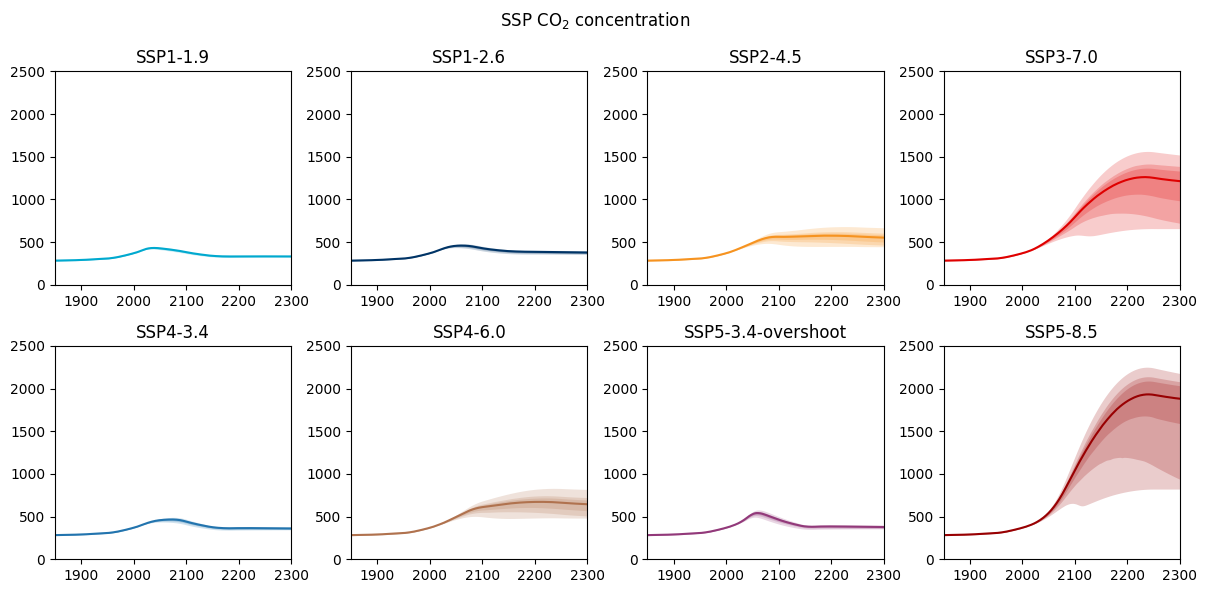

In [29]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.concentration.loc[dict(scenario=scenario, specie='CO2')],
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.concentration.loc[dict(scenario=scenario, specie='CO2')],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 2500)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP CO$_2$ concentration")
fig.tight_layout()

### Total effective radiative forcing

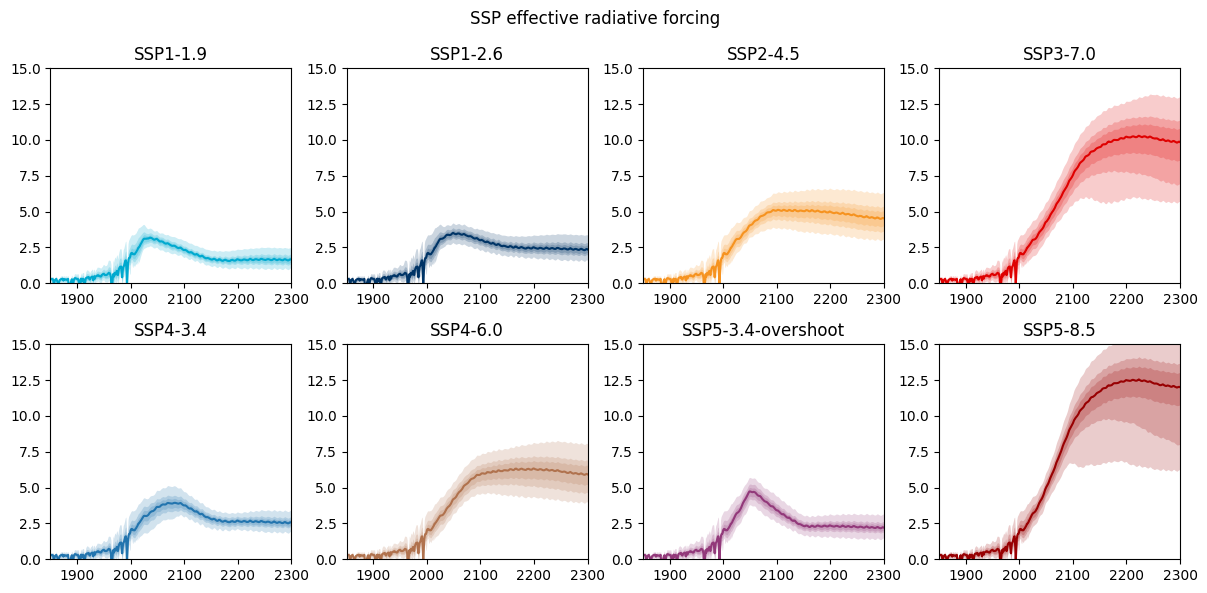

In [30]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.forcing_sum.loc[dict(scenario=scenario)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.forcing_sum.loc[dict(scenario=scenario)],
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.forcing_sum.loc[dict(scenario=scenario)],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 15)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP effective radiative forcing")
fig.tight_layout()

### CO2 airborne fraction

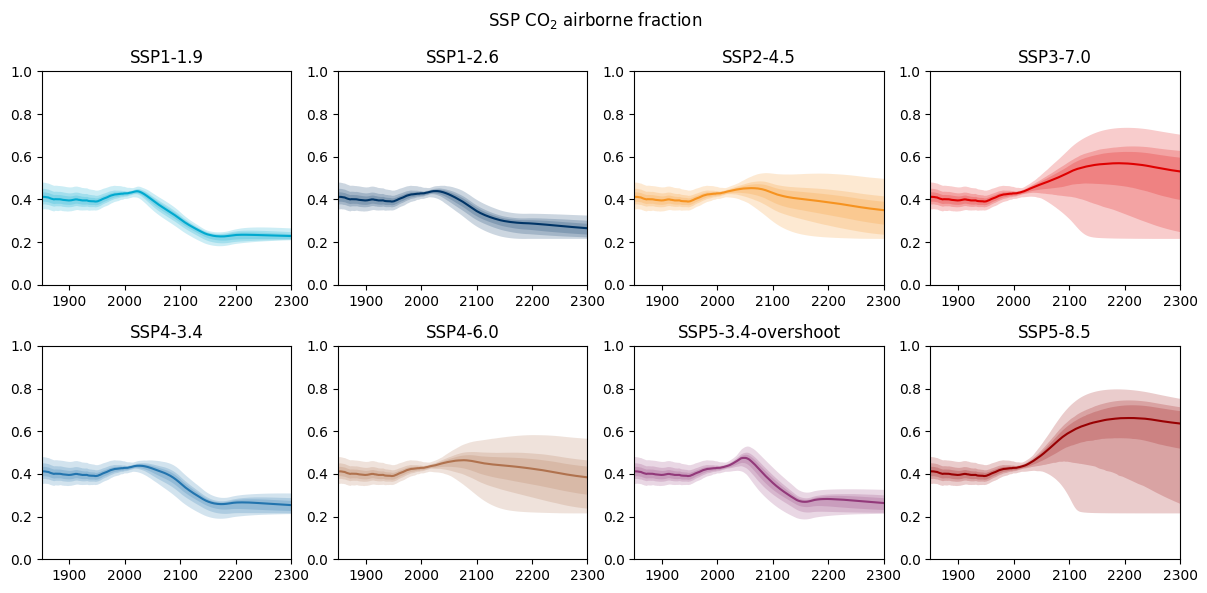

In [31]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.airborne_fraction.loc[dict(scenario=scenario, specie='CO2')],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 1)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP CO$_2$ airborne fraction")
fig.tight_layout()

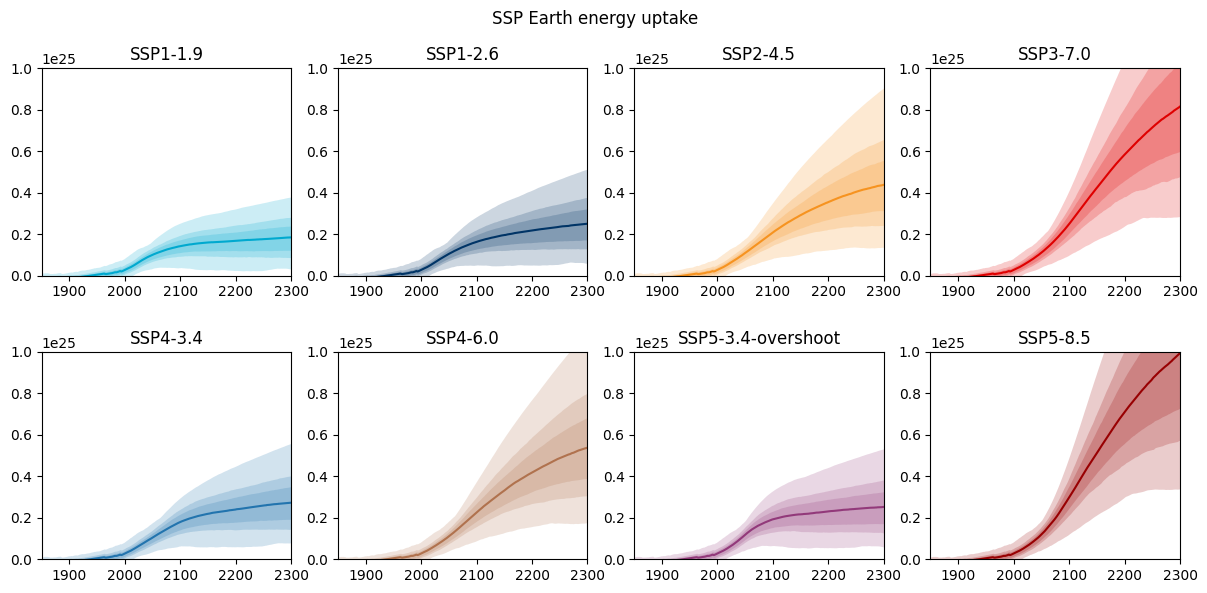

In [32]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.ocean_heat_content_change.loc[dict(scenario=scenario)],
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.ocean_heat_content_change.loc[dict(scenario=scenario)],
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.ocean_heat_content_change.loc[dict(scenario=scenario)],
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(0, 1e25)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP Earth energy uptake")
fig.tight_layout()